### ANN - Gen Matrix Encoded Dataset

In [1]:
# (r + 1) | (q - 1)
# (r + 1) | n
# q is a prime number
# n = 2^t
# r < n

In [2]:
%reset -f
import gc
gc.collect()

0

In [3]:
w0 = 4
z0 = 3

n = 27
q = 7
num_samples = 1000

num_unseen_samples = 20

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

np.random.seed(42)

In [5]:
def next_power_of_two(x):
    return 1 if x == 0 else 2**(x - 1).bit_length()

n_padded = next_power_of_two(n)

dataset = np.random.randint(0, q, size=(num_samples, n))

if n_padded > n:
    pad_width = n_padded - n
    dataset = np.pad(dataset, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)

print("Original n:", n)
print("Padded n:", n_padded)
print("Generated dataset shape:", dataset.shape)

Original n: 27
Padded n: 32
Generated dataset shape: (1000, 32)


In [6]:
print(dataset)
print(dataset.shape)
print(dataset[0].shape)

[[6 3 4 ... 0 0 0]
 [1 5 4 ... 0 0 0]
 [0 6 1 ... 0 0 0]
 ...
 [4 1 1 ... 0 0 0]
 [6 1 2 ... 0 0 0]
 [1 5 4 ... 0 0 0]]
(1000, 32)
(32,)


$$
\tilde{M}_{kj} = \left[ \left( \frac{w_0}{z_0} \right)^j \zeta^{kj} \right]_{k,j=0}^{n-1}
$$

In [7]:
def padded_generator_matrix(N, w0, z0):
    n = np.arange(N)
    k = n.reshape((N, 1))
    zeta = np.exp(-2j * np.pi / N)
    M_tilde = ((w0 / z0) ** n) * (zeta ** (k * n))
    return M_tilde

In [8]:
M_tilde = padded_generator_matrix(n_padded, w0, z0)
print(M_tilde.shape)

(32, 32)


In [9]:
encoded_dataset = np.array([np.dot(M_tilde, x) for x in dataset])
encoded_dataset[np.abs(encoded_dataset) < 1e-10] = 0
encoded_dataset = np.round(encoded_dataset, decimals=10)
print(encoded_dataset)

[[ 18563.60052945    +0.j          -3175.07412411+14542.65392496j
   -9480.13851167 -1549.89213738j ...   -850.18419129 +5788.51248279j
   -9480.13851167 +1549.89213738j  -3175.07412411-14542.65392496j]
 [ 26201.57565547    +0.j           -888.79870167+21381.54383229j
  -15711.89592314 +4225.02464251j ...  -8448.43948841+12321.54894128j
  -15711.89592314 -4225.02464251j   -888.79870167-21381.54383229j]
 [ 18708.3418798     +0.j          -3692.76914231+14315.81246485j
   -8001.63897938 -1445.78154582j ...  -2196.87866369 +4388.0650906j
   -8001.63897938 +1445.78154582j  -3692.76914231-14315.81246485j]
 ...
 [ 23026.93389135    +0.j          -1109.76273792+19062.65254237j
  -13040.7009937  +1311.43274328j ...  -3589.38928495 +6599.51636282j
  -13040.7009937  -1311.43274328j  -1109.76273792-19062.65254237j]
 [ 13466.17623911    +0.j          -3519.32538663 +9603.71035865j
   -6399.29947006 -1233.3778371j  ...  -1243.67319172 +6320.28545061j
   -6399.29947006 +1233.3778371j   -3519.3253866

In [10]:
encoded_dataset.shape

(1000, 32)

In [11]:
print(dataset[0])
print(encoded_dataset[0])

[6 3 4 6 2 4 4 6 1 2 6 2 2 4 3 2 5 4 1 3 5 5 1 3 4 0 3 0 0 0 0 0]
[18563.60052945    +0.j         -3175.07412411+14542.65392496j
 -9480.13851167 -1549.89213738j  -850.18419129 -5788.51248279j
  2813.63372348 -2457.36436449j  3312.0476391   +337.88077825j
  1059.2907911  +3489.68169028j -2366.82367016  +909.74502726j
  -210.29906943  +357.85181443j -3878.07651347  +373.95548592j
   -49.25036994 -6370.32567308j  6901.71964373 -1088.5938127j
  2896.76301761 +7252.43377368j -6714.83312544 +4427.90575271j
 -5496.28870703 -5330.43278044j  2828.24226801 -6162.17891893j
  6446.94186958    -0.j          2828.24226801 +6162.17891893j
 -5496.28870703 +5330.43278044j -6714.83312544 -4427.90575271j
  2896.76301761 -7252.43377368j  6901.71964373 +1088.5938127j
   -49.25036994 +6370.32567308j -3878.07651347  -373.95548592j
  -210.29906943  -357.85181443j -2366.82367016  -909.74502726j
  1059.2907911  -3489.68169028j  3312.0476391   -337.88077825j
  2813.63372348 +2457.36436449j  -850.18419129 +5788.5

In [12]:
X_real = np.real(encoded_dataset).astype(np.float32)
X_imag = np.imag(encoded_dataset).astype(np.float32)

In [13]:
print("x_real_min:  ", np.min(X_real))
print("x_real_max:  ", np.max(X_real))
print("x_imag_min:  ", np.min(X_imag))
print("x_imag_max:  ", np.max(X_imag))

x_real_min:   -25398.395
x_real_max:   37088.72
x_imag_min:   -32553.318
x_imag_max:   32553.318


In [14]:
# mean_real = np.mean(X_real, axis=0)
# std_real = np.std(X_real, axis=0) + 1e-8  # Avoid division by zero
# X_real = (X_real - mean_real) / std_real

# mean_imag = np.mean(X_imag, axis=0)
# std_imag = np.std(X_imag, axis=0) + 1e-8
# X_imag = (X_imag - mean_imag) / std_imag

In [15]:
print("x_real_min:  ", np.min(X_real))
print("x_real_max:  ", np.max(X_real))
print("x_imag_min:  ", np.min(X_imag))
print("x_imag_max:  ", np.max(X_imag))

x_real_min:   -25398.395
x_real_max:   37088.72
x_imag_min:   -32553.318
x_imag_max:   32553.318


In [16]:
X_real_imag = np.hstack([X_real, X_imag])

print("\nX_train :", X_real_imag.shape)
print(X_real_imag[0])


X_train : (1000, 64)
[ 18563.6      -3175.0742   -9480.139     -850.1842    2813.6338
   3312.0476    1059.2908   -2366.8237    -210.29907  -3878.0764
    -49.25037   6901.7197    2896.763    -6714.833    -5496.2886
   2828.2422    6446.942     2828.2422   -5496.2886   -6714.833
   2896.763     6901.7197     -49.25037  -3878.0764    -210.29907
  -2366.8237    1059.2908    3312.0476    2813.6338    -850.1842
  -9480.139    -3175.0742       0.       14542.654    -1549.8921
  -5788.5127   -2457.3643     337.88077   3489.6816     909.74506
    357.8518     373.95547  -6370.3257   -1088.5939    7252.4336
   4427.906    -5330.4326   -6162.1787      -0.        6162.1787
   5330.4326   -4427.906    -7252.4336    1088.5939    6370.3257
   -373.95547   -357.8518    -909.74506  -3489.6816    -337.88077
   2457.3643    5788.5127    1549.8921  -14542.654  ]


In [17]:
# normalize target data (integers 0-q to [0, 1])
y = dataset.astype(np.float32)
# y[:, :r] = 0
y_normalized = y / (q - 1)  # Scale to [0, 1]

labels = y_normalized


print("y: ")
print(y[0])
print("\ny_normalized: ")
print(y_normalized[0])

y: 
[6. 3. 4. 6. 2. 4. 4. 6. 1. 2. 6. 2. 2. 4. 3. 2. 5. 4. 1. 3. 5. 5. 1. 3.
 4. 0. 3. 0. 0. 0. 0. 0.]

y_normalized: 
[1.         0.5        0.6666667  1.         0.33333334 0.6666667
 0.6666667  1.         0.16666667 0.33333334 1.         0.33333334
 0.33333334 0.6666667  0.5        0.33333334 0.8333333  0.6666667
 0.16666667 0.5        0.8333333  0.8333333  0.16666667 0.5
 0.6666667  0.         0.5        0.         0.         0.
 0.         0.        ]


In [18]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(
    X_real_imag, labels, test_size=0.2, random_state=42
)

In [19]:
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

x_train shape: (800, 64), y_train shape: (800, 32)
x_test shape: (200, 64), y_test shape: (200, 32)


In [20]:
x_train = (x_train - x_train.mean()) / x_train.std()
x_test = (x_test - x_test.mean()) / x_test.std()

In [21]:
input_dim = x_train.shape[1]
output_dim = y_train.shape[1]
print(input_dim)
print(output_dim)

64
32


Compile Model

In [22]:
def custom_accuracy(y_true, y_pred):
    y_true_int = tf.cast(y_true*(q-1), tf.int32)
    y_pred_int = tf.cast(tf.round(y_pred*(q-1)), tf.int32)
    correct = tf.cast(tf.equal(y_true_int, y_pred_int), tf.float32)
    return tf.reduce_mean(correct)

# accuracy function that does not consider the padding
def custom_accuracy_without_padding(y_true, y_pred):
    y_true_int = tf.cast(y_true * (q - 1), tf.int32)
    y_pred_int = tf.cast(tf.round(y_pred * (q - 1)), tf.int32)
    mask = tf.concat(
        [tf.ones((tf.shape(y_true)[0], n), dtype=tf.float32),
         tf.zeros((tf.shape(y_true)[0], n_padded - n), dtype=tf.float32)],
        axis=1
    )
    correct = tf.cast(tf.equal(y_true_int, y_pred_int), tf.float32) * mask
    return tf.reduce_sum(correct) / tf.reduce_sum(mask)

def custom_mse(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tf.reduce_mean(tf.square(tf.cast(y_true - y_pred, tf.float32)))

In [23]:
def simple_NN(input_dim, output_dim, activation='relu'):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(n_padded, activation=activation),
        Dense(n_padded, activation=activation),
        Dense(n_padded, activation=activation),
        Dense(output_dim, activation='linear')  # Linear activation for regression
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=custom_mse,
        metrics=[custom_mse, custom_accuracy_without_padding]
    )
    return model


input_dim = x_train.shape[1]
output_dim = y_train.shape[1]
activation = LeakyReLU(negative_slope=0.1) #leaky_relu #relu
model = simple_NN(input_dim, output_dim, activation=activation)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         1,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,248 (20.50 KB)

 Trainable params: 5,248 (20.50 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# ------------- FLOP counts ---------------

# Create a concrete function
input_shape = (1, input_dim)  # batch size 1
concrete_func = tf.function(model).get_concrete_function(tf.TensorSpec(input_shape, tf.float32))

from tensorflow.python.profiler import model_analyzer
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder

profile_opts = ProfileOptionBuilder.float_operation()
flops = model_analyzer.profile(concrete_func.graph, options=profile_opts)

print('FLOPs:', flops.total_float_ops)

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


FLOPs: 10368


Training the NN

In [25]:
# from google.colab import drive
# drive.mount('/content/drive')

In [26]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

checkpoint_path = f"/content/drive/MyDrive/10 Masters/Research/error-correcting-codes/ThisIsTheCleanest/weights/ANN_model_{n}.keras"

model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

adjust_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

history = model.fit(
    x_train, y_train,
    epochs=500,
    batch_size=32,
    validation_data=(x_test, y_test),
    callbacks=[adjust_lr, early_stopping, model_checkpoint]
)

Epoch 1/500
15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - custom_accuracy_without_padding: 0.1076 - custom_mse: 0.3840 - loss: 0.3840
Epoch 1: val_loss improved from inf to 0.15946, saving model to /content/drive/MyDrive/10 Masters/Research/error-correcting-codes/ThisIsTheCleanest/weights/ANN_model_27.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - custom_accuracy_without_padding: 0.1151 - custom_mse: 0.3382 - loss: 0.3382 - val_custom_accuracy_without_padding: 0.1486 - val_custom_mse: 0.1588 - val_loss: 0.1595 - learning_rate: 0.0010
Epoch 2/500
14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - custom_accuracy_without_padding: 0.1411 - custom_mse: 0.1513 - loss: 0.1513   
Epoch 2: val_loss improved from 0.15946 to 0.10459, saving model to /content/drive/MyDrive/10 Masters/Research/error-correcting-codes/ThisIsTheCleanest/weights/ANN_model_27.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - custom_accuracy_without_padding: 0.1450 - custom_mse: 0.1433 - loss: 0.1433 - val_custom_accuracy_without_paddi

Evaluate

In [27]:
eval_results = model.evaluate(x_test, y_test)
print(f"Test results - Loss: {eval_results[0]}, MSE: {eval_results[1]}, Accuracy: {eval_results[2]}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - custom_accuracy_without_padding: 0.5527 - custom_mse: 0.0461 - loss: 0.0461 
Test results - Loss: 0.046747706830501556, MSE: 0.046886708587408066, Accuracy: 0.5453042387962341


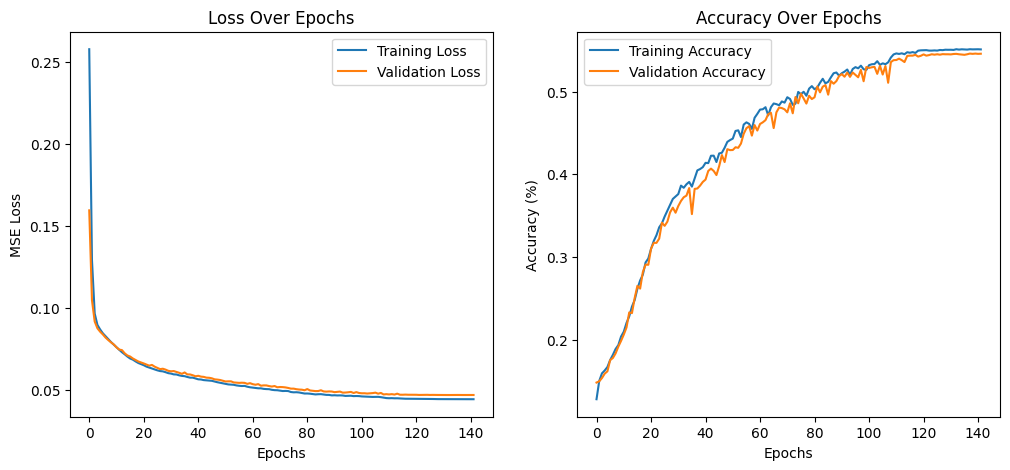

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['custom_accuracy_without_padding'], label='Training Accuracy')
plt.plot(history.history['val_custom_accuracy_without_padding'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

Predict

In [29]:
y_pred = model.predict(x_test)
y_pred_rescaled = y_pred * (q-1)
y_test_rescaled = y_test * (q-1)

print("Comparison of predictions and ground truth:")
for i in range(3):
    print(f"Sample {i+1}:")
    print(f"  Predicted:    {np.round(y_pred_rescaled[i]).astype(int)}")
    print(f"  Ground Truth: {np.round(y_test_rescaled[i]).astype(int)}")
    print("-" * 40)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Comparison of predictions and ground truth:
Sample 1:
  Predicted:    [3 3 3 3 2 3 3 3 3 3 2 2 3 1 3 2 5 1 4 3 4 4 6 5 2 3 1 0 0 0 0 0]
  Ground Truth: [5 6 5 1 3 4 1 1 6 2 3 1 4 0 3 2 5 1 4 3 4 4 6 5 2 3 1 0 0 0 0 0]
----------------------------------------
Sample 2:
  Predicted:    [4 3 3 3 3 3 3 3 2 4 3 3 3 2 3 2 1 2 0 1 1 5 2 1 4 0 4 0 0 0 0 0]
  Ground Truth: [1 4 1 3 3 3 0 5 5 2 4 3 3 1 3 1 1 2 0 1 1 5 2 1 4 0 4 0 0 0 0 0]
----------------------------------------
Sample 3:
  Predicted:    [3 3 3 3 3 3 3 3 3 2 3 3 3 4 3 3 5 1 4 6 0 4 3 2 3 4 4 0 0 0 0 0]
  Ground Truth: [2 6 0 2 2 1 3 4 2 6 4 1 0 5 2 3 5 1 4 6 0 4 3 2 3 4 4 0 0 0 0 0]
----------------------------------------


In [30]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)

print(f"R² Score: {r2:.4f}")

R² Score: 0.4228


In [31]:
# ---------------------- Inference time on Test Set ----------------------------

import time

_ = model.predict(x_test, verbose=0)  # warm up

times = []
for _ in range(100):
    start = time.perf_counter()
    _ = model.predict(x_test, verbose=0)
    end = time.perf_counter()
    times.append(end - start)

average_inference_time = np.mean(times)
print(f"Average batch inference time over 100 runs: {average_inference_time:.6f} seconds")

average_per_sample = average_inference_time / x_test.shape[0]
print(f"Average inference time per sample (from batch): {average_per_sample:.6f} seconds")

Average batch inference time over 100 runs: 0.109672 seconds
Average inference time per sample (from batch): 0.000548 seconds


In [32]:
# --------------------- Predictions on unseen samples -------------------------

np.random.seed(42)

unseen_data = np.random.randint(0, q, size=(num_unseen_samples, n))

padded_unseen_data = np.hstack((unseen_data, np.zeros((num_unseen_samples, n_padded - n))))

unseen_data_normalized = padded_unseen_data.astype(np.float32) / (q - 1)

unseen_encoded = np.array([np.dot(M_tilde, x) for x in padded_unseen_data])
unseen_encoded[np.abs(unseen_encoded) < 1e-10] = 0
unseen_encoded = np.round(unseen_encoded, decimals=10)

X_real_unseen = np.real(unseen_encoded).astype(np.float32)
X_imag_unseen = np.imag(unseen_encoded).astype(np.float32)

X_real_imag_unseen = np.hstack([X_real_unseen, X_imag_unseen])

X_real_imag_unseen = (X_real_imag_unseen - X_real_imag_unseen.mean()) / X_real_imag_unseen.std()

y_pred_unseen = model.predict(X_real_imag_unseen)

mse_unseen = tf.reduce_mean(tf.square(unseen_data_normalized - y_pred_unseen)).numpy()
print(f"MSE on unseen data: {mse_unseen}")

accuracy_unseen = custom_accuracy_without_padding(unseen_data_normalized, y_pred_unseen)
print(f"Accuracy on unseen data: {accuracy_unseen}")

num_display_samples = 3
for i in range(num_display_samples):
    print(f"Sample {i+1}:")
    true_labels = padded_unseen_data[i]
    pred_scaled = y_pred_unseen[i] * (q - 1)
    pred_rounded = tf.round(pred_scaled).numpy().astype(int)
    print(f"{true_labels}: True values")
    print(f"{pred_rounded}: Predicted values")
    print("-" * 20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
MSE on unseen data: 0.04372256621718407
Accuracy on unseen data: 0.5481481552124023
Sample 1:
[6. 3. 4. 6. 2. 4. 4. 6. 1. 2. 6. 2. 2. 4. 3. 2. 5. 4. 1. 3. 5. 5. 1. 3.
 4. 0. 3. 0. 0. 0. 0. 0.]: True values
[3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 2 5 4 1 3 5 5 1 3 4 0 3 0 0 0 0 0]: Predicted values
--------------------
Sample 2:
[1. 5. 4. 3. 0. 0. 2. 2. 6. 1. 3. 3. 6. 5. 5. 6. 5. 2. 3. 6. 3. 0. 2. 4.
 2. 6. 4. 0. 0. 0. 0. 0.]: True values
[3 3 4 4 4 3 3 3 3 3 3 4 4 4 4 6 5 2 3 6 3 0 2 4 2 6 4 0 0 0 0 0]: Predicted values
--------------------
Sample 3:
[0. 6. 1. 3. 0. 3. 5. 1. 1. 0. 1. 4. 1. 3. 3. 6. 3. 6. 3. 4. 6. 2. 5. 0.
 3. 1. 3. 0. 0. 0. 0. 0.]: True values
[3 3 3 4 3 3 3 4 3 3 3 3 2 2 3 6 3 6 3 4 6 2 5 0 3 1 3 0 0 0 0 0]: Predicted values
--------------------


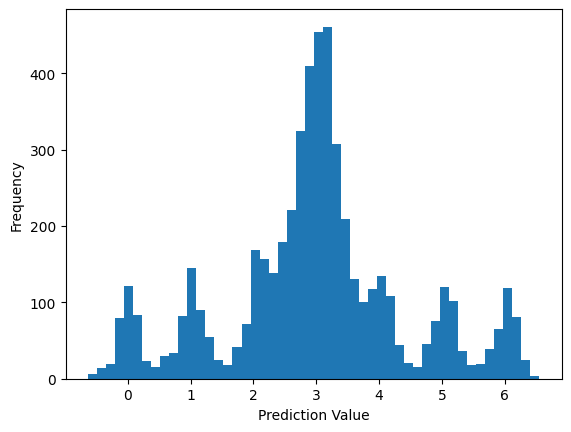

In [33]:
import matplotlib.pyplot as plt

# exclude zero pads
y_pred_first_n = y_pred[:, :n]
y_pred_first_n_rescaled = y_pred_first_n * (q - 1)

plt.hist(y_pred_first_n_rescaled.flatten(), bins=50)
plt.xlabel('Prediction Value')
plt.ylabel('Frequency')
plt.show()

In [34]:
# for layer in model.layers:
#     if layer.trainable_variables:  # Check if the layer has trainable variables
#         for i, var in enumerate(layer.trainable_variables):
#             print(f"{layer.name} - Variable {i} ({var.name}): values: {var.numpy()}")
#     else:
#         print(layer.name, "has no trainable variables.")